# COVID-19, Analiza eksploracyjna - badanie zmienności i powiązań między danymi z wykorzystaniem wykresów

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from math import sqrt
from sklearn.metrics import mean_squared_error

Uzupełniamy liczbę ludności, która posłuży do liczenia współczynników charakteryzujących pandemię.

In [2]:
# Worldometer - populacja Polski
N = 37827088

Wczytajemy przygotowane dane z pliku.

In [3]:
df = pd.read_excel("poland_covid_formatted.xlsx", index_col = 0)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 0 to 288
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Data                             289 non-null    datetime64[ns]
 1   Dzień pandemii                   289 non-null    int64         
 2   Nowe przypadki                   289 non-null    int64         
 3   Nowe zgony                       289 non-null    int64         
 4   Nowe wyzdrowienia                289 non-null    int64         
 5   Suma potwierdzonych przypadków   289 non-null    int64         
 6   Suma zgonów                      289 non-null    int64         
 7   Suma wyzdrowień                  289 non-null    int64         
 8   Liczba aktywnych przypadków      289 non-null    int64         
 9   Dobowa liczba wykonanych testów  289 non-null    int64         
 10  punkty restrykcji                289 non-null    int64        

In [4]:
# dodanie kolumny z odsetkiem dodatnich wyników testów
df.loc[:,'Suma podatnych na zakażenie'] = N - df['Liczba aktywnych przypadków'] - df['Suma wyzdrowień'] - df['Suma zgonów']

In [5]:
# funkcja licząca kroczącą średnią 7 dniową dla całej kolumny
def mean_7d(df, column):
    n = df[column].size
    df_temp = pd.DataFrame()
    for i in range(6,n):
        mean_7d = 0
        for j in range(7):
            mean_7d += df[column][i-j]/7
        df_temp.loc[i-6,'mean_7d'] = mean_7d
    return np.array(df_temp)

# Root mean squared error
def RMSE(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))

# Pochodna do metody gradientowej
def feature_derivative(errors, features):
    derivative = 2*np.dot(errors, features)
    return(derivative)

In [6]:
# Policzenie średnich 7-dniowych dla całej tabeli
df_7d = pd.DataFrame()
df_7d.loc[:,'Data'] = df['Data'][6:]
df_7d.loc[:,'Suma podatnych na zakażenie'] = mean_7d(df, 'Suma podatnych na zakażenie')
df_7d.loc[:,'Liczba aktywnych przypadków'] = mean_7d(df, 'Liczba aktywnych przypadków')
df_7d.loc[:,'Suma wyzdrowień'] = mean_7d(df, 'Suma wyzdrowień')
df_7d.loc[:,'Suma zgonów'] = mean_7d(df, 'Suma zgonów')
df_7d = df_7d.reset_index()
print(df_7d.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   index                        283 non-null    int64         
 1   Data                         283 non-null    datetime64[ns]
 2   Suma podatnych na zakażenie  283 non-null    float64       
 3   Liczba aktywnych przypadków  283 non-null    float64       
 4   Suma wyzdrowień              283 non-null    float64       
 5   Suma zgonów                  283 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 13.4 KB
None


In [37]:
X = df_7d['Data'] 
S_db = df['Suma podatnych na zakażenie']
I_db = df['Liczba aktywnych przypadków']
R_db = df['Suma wyzdrowień']
D_db = df['Suma zgonów']
S_7d = df_7d['Suma podatnych na zakażenie']
I_7d = df_7d['Liczba aktywnych przypadków']
R_7d = df_7d['Suma wyzdrowień']
D_7d = df_7d['Suma zgonów']

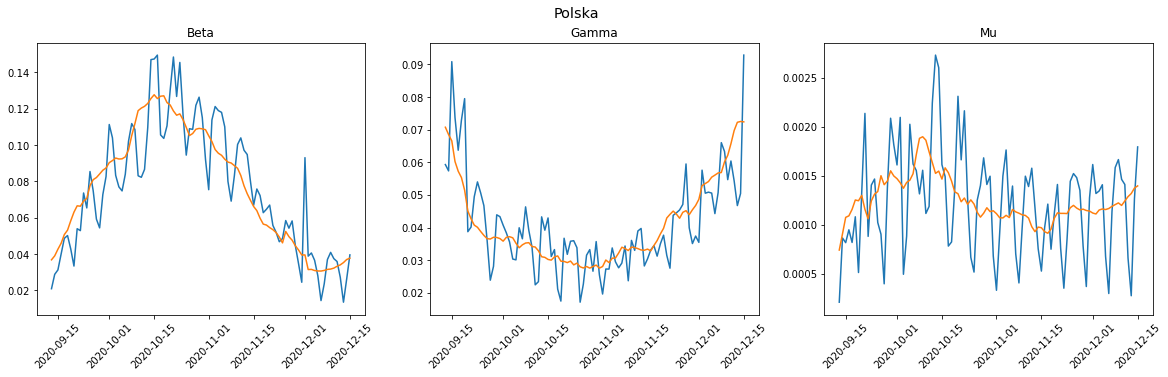

In [103]:
start = 187 # 12.09
stop = 282 # 16.12
B_db = np.zeros(289)
G_db = np.zeros(289)
M_db = np.zeros(289)
B_7d = np.zeros(289)
G_7d = np.zeros(289)
M_7d = np.zeros(289)
for i in range(start+1,stop,1):
    B_db[i] = (-1)*(S_db[i]-S_db[i-1])*(N/(I_db[i-1]*S_db[i-1]))
    G_db[i] = (R_db[i]-R_db[i-1])/I_db[i-1]
    M_db[i] = (D_db[i]-D_db[i-1])/I_db[i-1]
    B_7d[i] = (-1)*(S_7d[i]-S_7d[i-1])*(N/(I_7d[i-1]*S_7d[i-1]))
    G_7d[i] = (R_7d[i]-R_7d[i-1])/I_7d[i-1]
    M_7d[i] = (D_7d[i]-D_7d[i-1])/I_7d[i-1]
    
plt.figure(figsize=(20,5))
plt.suptitle("Polska", fontsize="x-large")
plt.subplot(1,3,1).set_title('Beta')
plt.plot(X[start+1:stop],B_db[start+1:stop])
plt.plot(X[start+1:stop],B_7d[start+1:stop])
plt.xticks(rotation=45)
plt.subplot(1,3,2).set_title('Gamma')
plt.plot(X[start+1:stop],G_db[start+1:stop])
plt.plot(X[start+1:stop],G_7d[start+1:stop])
plt.xticks(rotation=45)
plt.subplot(1,3,3).set_title('Mu')
plt.plot(X[start+1:stop],M_db[start+1:stop])
plt.plot(X[start+1:stop],M_7d[start+1:stop])
plt.xticks(rotation=45)
plt.show()

In [41]:
print("Beta: {:.5f}".format(B_7d[start+1:stop].mean()))
print("Gamma: {:.5f}".format(G_7d[start+1:stop].mean()))
print("Mu: {:.5f}".format(M_7d[start+1:stop].mean()))

Beta: 0.07654
Gamma: 0.04102
Mu: 0.00125


In [ ]:
for i in range(start+1,stop,1):
    dSdt = (-1)*beta*I_cal[i-1]*S_cal[i-1]/N
    S_cal[i] = S_cal[i-1] + dSdt
    dIdt = (beta*I_cal[i-1]*S_cal[i-1]/N)-(gamma*I_cal[i-1])-(mu*I_cal[i-1])
    I_cal[i] = I_cal[i-1] + dIdt
    dRdt = gamma*I_cal[i-1]
    R_cal[i] = R_cal[i-1] + dRdt
    dDdt = mu*I_cal[i-1]
    D_cal[i] = D_cal[i-1] + dDdt

In [ ]:
for i in range(start+1,stop,1):
    dSdt = (-1)*beta*I_db[i-1]*S_db[i-1]/N
    S_cal[i] = S_db[i-1] + dSdt
    dIdt = (beta*I_db[i-1]*S_db[i-1]/N)-(gamma*I_db[i-1])-(mu*I_db[i-1])
    I_cal[i] = I_db[i-1] + dIdt
    dRdt = gamma*I_db[i-1]
    R_cal[i] = R_db[i-1] + dRdt
    dDdt = mu*I_db[i-1]
    D_cal[i] = D_db[i-1] + dDdt

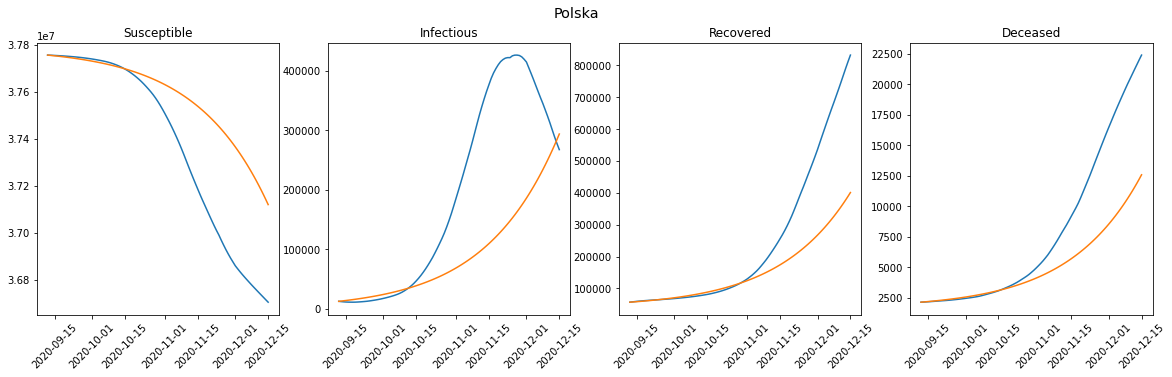

In [104]:
start = 187 # 12.09
stop = 282 # 16.12

I0 = I[start]
R0 = R[start]
D0 = D[start]
S0 = N - I0 - R0 - D0

S_cal = np.zeros(282)
I_cal = np.zeros(282)
R_cal = np.zeros(282)
D_cal = np.zeros(282)

S_cal[start] = S_7d[start]
I_cal[start] = I_7d[start]
R_cal[start] = R_7d[start]
D_cal[start] = D_7d[start]

beta = B_7d[start+1:stop].mean()
gamma = G_7d[start+1:stop].mean()
mu = M_7d[start+1:stop].mean()

def plot_SIRD(beta, gamma, mu):
    for i in range(start+1,stop,1):
        dSdt = (-1)*beta*I_cal[i-1]*S_cal[i-1]/N
        S_cal[i] = S_cal[i-1] + dSdt
        dIdt = (beta*I_cal[i-1]*S_cal[i-1]/N)-(gamma*I_cal[i-1])-(mu*I_cal[i-1])
        I_cal[i] = I_cal[i-1] + dIdt
        dRdt = gamma*I_cal[i-1]
        R_cal[i] = R_cal[i-1] + dRdt
        dDdt = mu*I_cal[i-1]
        D_cal[i] = D_cal[i-1] + dDdt

    plt.figure(figsize=(20,5))
    plt.suptitle("Polska", fontsize="x-large")
    plt.subplot(1,4,1).set_title('Susceptible')
    plt.plot(X[start:stop],S_7d[start:stop])
    plt.plot(X[start:stop],S_cal[start:stop])
    plt.xticks(rotation=45)
    plt.subplot(1,4,2).set_title('Infectious')
    plt.plot(X[start:stop],I_7d[start:stop])
    plt.plot(X[start:stop],I_cal[start:stop])
    plt.xticks(rotation=45)
    plt.subplot(1,4,3).set_title('Recovered')
    plt.plot(X[start:stop],R_7d[start:stop])
    plt.plot(X[start:stop],R_cal[start:stop])
    plt.xticks(rotation=45)
    plt.subplot(1,4,4).set_title('Deceased')
    plt.plot(X[start:stop],D_7d[start:stop])
    plt.plot(X[start:stop],D_cal[start:stop])
    plt.xticks(rotation=45)
    plt.show()
    
plot_SIRD(beta, gamma, mu)

In [59]:
print("S_RMSE: {:.2f}".format(RMSE(S_db[start+1:stop],S_cal[start+1:stop])))
print("I_RMSE: {:.2f}".format(RMSE(I_db[start+1:stop],I_cal[start+1:stop])))
print("R_RMSE: {:.2f}".format(RMSE(R_db[start+1:stop],R_cal[start+1:stop])))
print("D_RMSE: {:.2f}".format(RMSE(D_db[start+1:stop],D_cal[start+1:stop])))
sird_rmse = RMSE(S_db[start+1:stop],S_cal[start+1:stop]) + RMSE(I_db[start+1:stop],I_cal[start+1:stop]) + RMSE(R_db[start+1:stop],R_cal[start+1:stop]) + RMSE(D_db[start+1:stop],D_cal[start+1:stop])
print("sum: {:.2f}".format(sird_rmse))

S_RMSE: 244319.79
I_RMSE: 138634.45
R_RMSE: 128881.43
D_RMSE: 3638.81
sum: 515474.48


Beta: 0.08398
Gamma: 0.03995
Mu: 0.00162


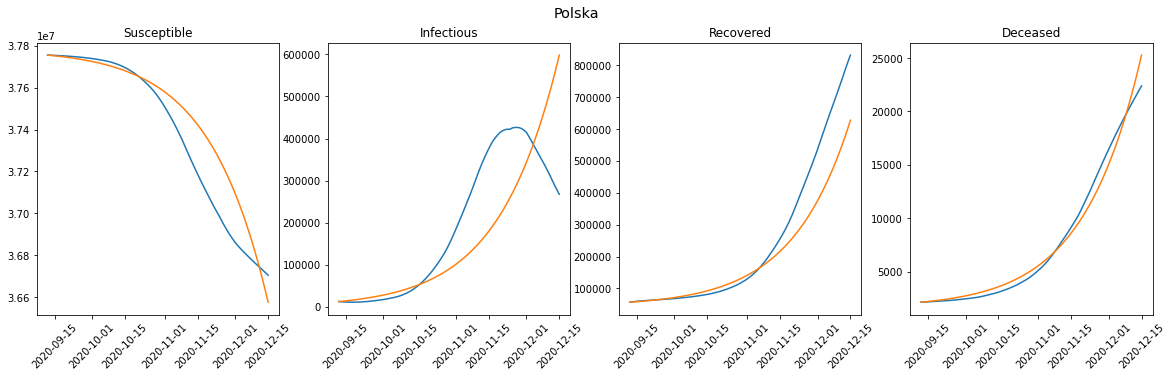

In [110]:
new_minimum = 515475
min_beta = 0
min_gamma = 0
min_mu = 0
for day in range(start+1,stop,1):
    beta = B_db[day]
    gamma = G_db[day]
    mu = M_db[day]

    for i in range(start+1,stop,1):
        dSdt = (-1)*beta*I_cal[i-1]*S_cal[i-1]/N
        S_cal[i] = S_cal[i-1] + dSdt
        dIdt = (beta*I_cal[i-1]*S_cal[i-1]/N)-(gamma*I_cal[i-1])-(mu*I_cal[i-1])
        I_cal[i] = I_cal[i-1] + dIdt
        dRdt = gamma*I_cal[i-1]
        R_cal[i] = R_cal[i-1] + dRdt
        dDdt = mu*I_cal[i-1]
        D_cal[i] = D_cal[i-1] + dDdt

    sum_rmse = RMSE(S_db[start+1:stop],S_cal[start+1:stop]) + RMSE(I_db[start+1:stop],I_cal[start+1:stop]) + RMSE(R_db[start+1:stop],R_cal[start+1:stop]) + RMSE(D_db[start+1:stop],D_cal[start+1:stop])
    if sum_rmse < new_minimum:
        new_minimum = sum_rmse
        min_beta = B_db[day]
        min_gamma = G_db[day]
        min_mu  = M_db[day]
        
print("Beta: {:.5f}".format(min_beta))
print("Gamma: {:.5f}".format(min_gamma))
print("Mu: {:.5f}".format(min_mu)) 
plot_SIRD(min_beta, min_gamma, min_mu)

In [101]:
start_beta = 0.0537 - 0.005
min_beta = 0
new_minimum = 244320
for j in np.linspace(0,0.01,num=1001):
    beta = start_beta+j
    for i in range(start+1,stop,1):
        dSdt = (-1)*beta*I_db[i-1]*S_db[i-1]/N
        S_cal[i] = S_db[i-1] + dSdt
    
    sum_rmse = RMSE(S_db[start+1:stop],S_cal[start+1:stop])
    if sum_rmse < new_minimum:
        new_minimum = sum_rmse
        min_beta  = beta
        
print(start_beta)
print(min_beta)

0.0487
0.053720000000000004


In [94]:
start_gamma = 0.04102 - 0.005
min_gamma = 0
new_minimum = 244320
for j in np.linspace(0,0.01,num=1001):
    gamma = start_gamma+j
    for i in range(start+1,stop,1):
        dRdt = gamma*I_db[i-1]
        R_cal[i] = R_db[i-1] + dRdt
    
    sum_rmse = RMSE(R_db[start+1:stop],R_cal[start+1:stop])
    if sum_rmse < new_minimum:
        new_minimum = sum_rmse
        min_gamma  = gamma
        
print(min_gamma)

0.04397


In [93]:
start_mu = 0.00125 - 0.0005
min_mu = 0
new_minimum = 244320
for j in np.linspace(0,0.001,num=1001):
    mu = start_mu+j
    for i in range(start+1,stop,1):
        dDdt = mu*I_db[i-1]
        D_cal[i] = D_cal[i-1] + dDdt
    
    sum_rmse = RMSE(D_db[start+1:stop],D_cal[start+1:stop])
    if sum_rmse < new_minimum:
        new_minimum = sum_rmse
        min_mu  = mu
        
print(min_mu)

0.00112


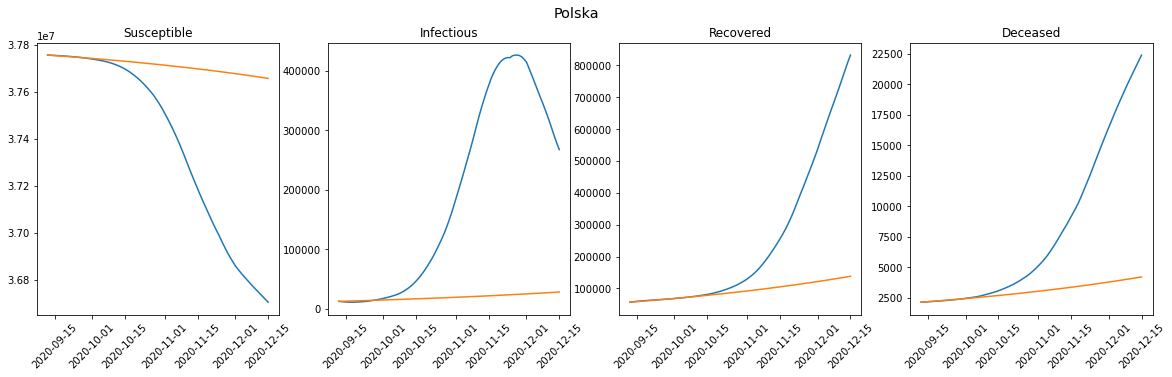

In [107]:
plot_SIRD(min_beta, min_gamma, min_mu)